# Expected error probabilities of Clarke maximum a posteriori strategies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, binom
from scipy.stats import multinomial

In [2]:
# box and measurement parameters
N = 20 # half number of photons per box

In [10]:
def multinomial(lst):
    res, i = 1, sum(lst)
    i0 = lst.index(max(lst))
    for a in lst[:i0] + lst[i0+1:]:
        for j in range(1,a+1):
            res *= i
            res //= j
            i -= 1
    return res

def likelihood( n1, n2 , theta = 0, N = 1 , box = "A"):

    P = np.zeros( (len(n1) , len(n2)) , dtype="float64")
    
    c = np.cos(2*theta)
    s = np.sin(2*theta)
    
    if box == "C":
        p = 0.5*c**2
        q = 0.5*(1 - p)
        for j in range(len(n1)):

            C = np.power( p , n1[j])*np.power( q , 2*N - n1[j])
            for k in range(len(n2)):
                if n1[j] + n2[k] <= 2*N:
                    P[j,k] += C*binom( n1[j] + n2[k], n1[j])*binom( 2*N , 2*N - n1[j] - n2[k])
    else:
        
        p1 = (2 + np.sqrt(2))/4*c**2
        q1 = (2 - np.sqrt(2))/4*c**2
        
        if box == "A":
            p2 = (np.sqrt(2+np.sqrt(2))*s + np.sqrt(2-np.sqrt(2)))**2/8
            q2 =(np.sqrt(2-np.sqrt(2))*s - np.sqrt(2+np.sqrt(2)))**2/8
        elif box == "B":
            p2 = (np.sqrt(2+np.sqrt(2))*s - np.sqrt(2-np.sqrt(2)))**2/8
            q2 = (np.sqrt(2-np.sqrt(2))*s + np.sqrt(2+np.sqrt(2)))**2/8
            
        p3 = 1 - p1 - p2
        q3 = 1 - q1 - q2
        
        for j in range(len(n1)):
            for k in range(len(n2)):
                if n1[j] + n2[k] <= 2*N:
                    n1min = np.maximum(0, n1[j]-N)
                    n1max = np.minimum(n1[j], N)
                    n2min = np.maximum(0, n2[k]-N)
                    for m1 in range(n1min, n1max + 1):
                        n2max = np.minimum(n2[k], N - m1)
                        C0 = np.power(p1 , m1)*np.power(q1 , n1[j] - m1)
                        for m2 in range(n2min, n2max+1): # sorry for the nested fors i dont have much time left to submit my thesis
                            C  = C0*binom( m1 + m2 , m2)*binom(N, m1 + m2)
                            C *= binom( n1[j] + n2[k] - m1 - m2, n2[k] - m2)*binom(N, n1[j] + n2[k] - m1 - m2)
                            C *= np.power(p2 , m2)*np.power(p3 , N - m1 - m2)
                            C *= np.power(q2 , n2[k] - m2)*np.power(q3 , N + m1 + m2 - n1[j] - n2[k])
                            P[j, k] += C
    
    return P

def EEP( LHA, LHB, LHC ): # expected error probability
    
    # inferring events when the maximum likelihood is well defined
    Ainfer_event = (LHA>LHB)*(LHA>LHC)
    Binfer_event = (LHB>LHA)*(LHB>LHC)
    Cinfer_event = (LHC>LHA)*(LHC>LHB)
    
    ABcoincidence = (LHA==LHB)*(LHA!=LHC)
    ACcoincidence = (LHA==LHC)*(LHA!=LHB)
    BCcoincidence = (LHB==LHC)*(LHA!=LHB)
    
    ABCcoincidence = (LHA==LHB)*(LHA==LHC)
    
    # EXPECTED CONDITIONAL SUCCESS PROBABILITIES
    ESPA = LHA[Ainfer_event].sum() # when the maximum likelihood is evidently A, infer A correctly
    ESPA += LHA[ABcoincidence].sum()/2+LHA[ACcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPA += LHA[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    ESPB = LHB[Binfer_event].sum() # when the maximum likelihood is evidently B, infer B correctly
    ESPB += LHB[ABcoincidence].sum()/2+LHB[BCcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPB += LHB[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    ESPC = LHC[Cinfer_event].sum() # when the maximum likelihood is evidently C, infer C correctly
    ESPC += LHC[ACcoincidence].sum()/2+LHC[BCcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPC += LHC[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    EEP_dict = {
        "A": 1 - ESPA,
        "B": 1 - ESPB,
        "C": 1 - ESPC,
        "Overall": 1 - (ESPA+ESPB+ESPC)/3.
    }
    
    return EEP_dict

In [11]:
theta = 0*np.arcsin(np.tan(np.pi/8))/2
LHA = likelihood( np.arange(2*N) , np.arange(2*N) , theta , N, "A")
LHB = likelihood( np.arange(2*N) , np.arange(2*N) , theta , N, "B")
LHC = likelihood( np.arange(2*N) , np.arange(2*N) , theta , N, "C")

np.save("ClarkeLikelihood_BoxA_theta{:.3f}_N{:d}".format(theta, 2*N), LHA)
np.save("ClarkeLikelihood_BoxB_theta{:.3f}_N{:d}".format(theta, 2*N), LHB)
np.save("ClarkeLikelihood_BoxC_theta{:.3f}_N{:d}".format(theta, 2*N), LHC)

In [12]:
N1 , N2 = np.meshgrid(np.arange(2*N) , np.arange(2*N))

print( (N1.T*LHA).sum(), (N2.T*LHA).sum() )
print( (N1.T*LHB).sum(), (N2.T*LHB).sum() )
print( (N1.T*LHC).sum(), (N2.T*LHC).sum()  )

19.99999999999998 9.999999999999988
19.99999999999998 9.999999999999988
19.99999999996362 10.0


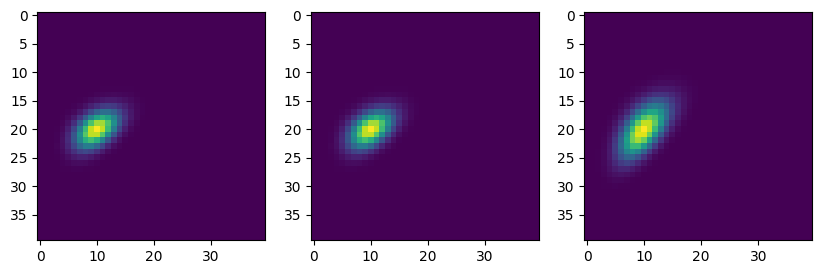

In [20]:
fig, ax = plt.subplots( 1 , 3 , figsize=(10,4) )
ax[0].imshow(LHA)
ax[1].imshow(LHB)
ax[2].imshow(LHC)

In [14]:
EEP(LHA , LHB, LHC )

{'A': 0.5000000000000006,
 'B': 0.5000000000000006,
 'C': 0.5704094921575233,
 'Overall': 0.5234698307191747}

In [18]:
LHC.sum()

0.9999999999990905

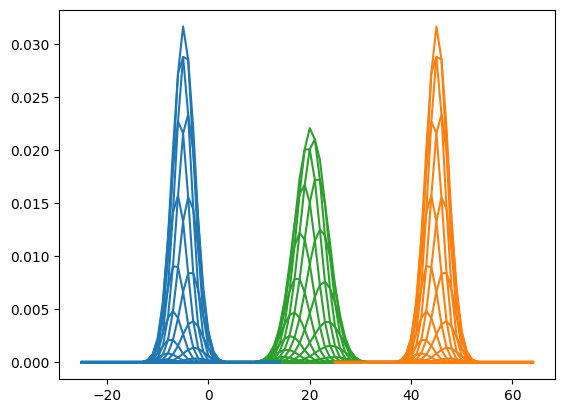

In [19]:
#plt.plot(np.arange(2*N), LHA, color="C0")
#plt.plot(np.arange(2*N), LHB, color="C1")
plt.plot(np.arange(2*N), LHC, color="C2")
plt.plot(25+np.arange(2*N), LHA, color="C1")
plt.plot(-25+np.arange(2*N), LHB, color="C0")
plt.show()

# For varying values of N

In [31]:
theta = np.pi/2
N = np.arange(50+1)

EEPs = np.zeros((len(N),4), dtype="object")

for j in range(len(N)):
    print(N[j])
    LHA = np.round(likelihood( np.arange(2*N[j]) , np.arange(2*N[j]), theta , N[j], "A"), 12)
    LHB = np.round(likelihood( np.arange(2*N[j]) , np.arange(2*N[j]), theta , N[j], "B"), 12)
    LHC = np.round(likelihood( np.arange(2*N[j]) , np.arange(2*N[j]), theta , N[j], "C"), 12)
    
    EEPs = np.array(list(EEP(LHA,LHB,LHC).values()))
    np.save("3BPClarkeMAPEEP_theta{:.3f}_N{:d}.npy".format(theta, 2*N[j]), EEPs)
    
#np.save("3BPClarkeMAPEEP_Nmax{:d}.npy".format(2*Nmax), EEPs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


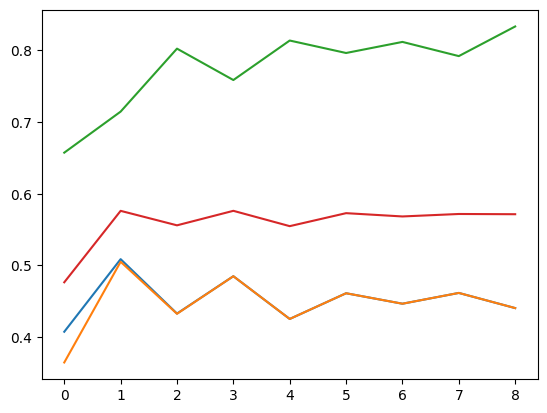

In [47]:
plt.plot(EEPs[1:,0])
plt.plot(EEPs[1:,1])
plt.plot(EEPs[1:,2])
plt.plot(EEPs[1:,3])

# For varying values of $\theta$

In [21]:
theta = np.linspace(0, np.pi, 101)
N = 50

for j in range(len(theta)):
    print(theta[j])
    LHA = np.round(likelihood( np.arange(2*N) , np.arange(2*N), theta[j] , N, "A"), 12)
    LHB = np.round(likelihood( np.arange(2*N) , np.arange(2*N), theta[j] , N, "B"), 12)
    LHC = np.round(likelihood( np.arange(2*N) , np.arange(2*N), theta[j] , N, "C"), 12)
    
    EEPs = np.array(list(EEP(LHA,LHB,LHC).values()))
    np.save("3BPClarkeMAPEEP_theta{:.3f}_N{:d}.npy".format(theta[j], 2*N), EEPs)

0.0
0.031415926535897934
0.06283185307179587
0.0942477796076938
0.12566370614359174
0.15707963267948966
0.1884955592153876
0.21991148575128555
0.25132741228718347
0.2827433388230814
0.3141592653589793
0.3455751918948773
0.3769911184307752
0.4084070449666731
0.4398229715025711
0.471238898038469
0.5026548245743669
0.5340707511102649
0.5654866776461628
0.5969026041820608
0.6283185307179586
0.6597344572538566
0.6911503837897546
0.7225663103256524
0.7539822368615504
0.7853981633974484
0.8168140899333463
0.8482300164692442
0.8796459430051422
0.9110618695410401
0.942477796076938
0.9738937226128359
1.0053096491487339
1.0367255756846319
1.0681415022205298
1.0995574287564276
1.1309733552923256
1.1623892818282235
1.1938052083641215
1.2252211349000195
1.2566370614359172
1.2880529879718152
1.3194689145077132
1.3508848410436112
1.3823007675795091
1.4137166941154071
1.4451326206513049
1.4765485471872029
1.5079644737231008
1.5393804002589988
1.5707963267948968
1.6022122533307945
1.6336281798666925
1.6

In [22]:
EEPs = np.zeros((len(theta),4), dtype="object")

for j in range(len(theta)):
    
    EEPs[j] = np.load("3BPClarkeMAPEEP_theta{:.3f}_N{:d}.npy".format(theta[j], 2*N))

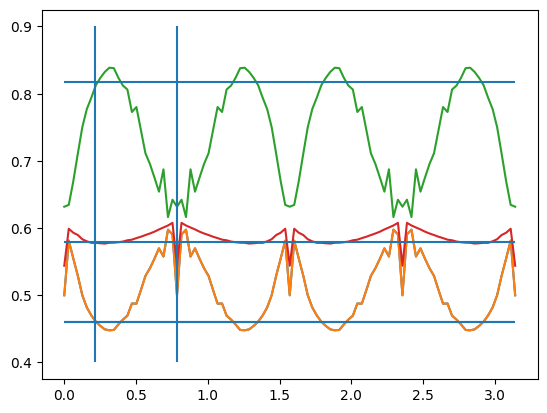

In [24]:
plt.plot(theta, EEPs[:,0])
plt.plot(theta, EEPs[:,1])
plt.plot(theta, EEPs[:,2])
plt.plot(theta, EEPs[:,3])
plt.vlines([np.arcsin(np.tan(np.pi/8))/2],0.4,0.9)
plt.hlines([0.459569669163, 0.459569669163, 0.81674546902, 0.5786282691153333],0,np.pi)
plt.show()

In [28]:
np.arcsin(np.tan(np.pi/8))/2

0.21353929319623804

In [29]:
np.arcsin(1/np.sqrt(3))/2

0.3077398543351937